# 🔬 Skin Cancer Classification with MobileNetV2 + Youden's J Threshold Optimization

This notebook implements a comprehensive skin cancer classification system using:
- **MobileNetV2** transfer learning for image classification
- **Focal Loss** for handling class imbalance
- **Youden's J Index** for optimizing per-class decision thresholds
- **HAM10000 dataset** with 7 lesion classes

## Melhorias Implementadas
- ✅ Split por lesion_id (evita data leakage)
- ✅ Focal Loss (melhor para classes desbalanceadas)
- ✅ Youden's J para otimização de thresholds (mais simples e eficiente que RL)
- ✅ Augmentação aprimorada (rotação, flip, zoom, contraste, brilho)

## Dataset Classes
| Abbreviation | Full Name | Category |
|--------------|-----------|----------|
| akiec | Actinic Keratoses | Pre-cancerous |
| bcc | Basal Cell Carcinoma | Malignant |
| bkl | Benign Keratosis | Benign |
| df | Dermatofibroma | Benign |
| mel | Melanoma | Malignant (Most Dangerous) |
| nv | Melanocytic Nevi | Benign |
| vasc | Vascular Lesions | Benign |

---

## 1. Import Libraries and Configure Environment

In [1]:
# Diagnóstico completo e configuração de CUDA
import sys
import os

print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")

# Verificar se é o ambiente correto
if "skincancer" in sys.executable.lower():
    print("✓ Ambiente skincancer detectado!")
else:
    print("⚠ ATENÇÃO: Não está usando o ambiente skincancer!")

# Configurar caminhos CUDA antes de importar TensorFlow
conda_prefix = os.path.dirname(os.path.dirname(sys.executable))
cuda_path = os.path.join(conda_prefix, "Library", "bin")

if os.path.exists(cuda_path):
    print(f"\n📁 Configurando CUDA path: {cuda_path}")
    os.environ['PATH'] = cuda_path + os.pathsep + os.environ.get('PATH', '')
    
    # Verificar DLLs CUDA
    cuda_dlls = [f for f in os.listdir(cuda_path) if 'cuda' in f.lower() or 'cudnn' in f.lower()]
    if cuda_dlls:
        print(f"✓ DLLs CUDA encontradas: {len(cuda_dlls)}")
        for dll in cuda_dlls[:5]:
            print(f"  - {dll}")
    else:
        print("⚠ Nenhuma DLL CUDA encontrada!")
else:
    print(f"⚠ Pasta CUDA não encontrada: {cuda_path}")

# Agora importar TensorFlow
print("\n" + "="*50)
print("Carregando TensorFlow...")
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")

# Tentar detectar GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ GPUs detectadas: {len(gpus)}")
    for gpu in gpus:
        print(f"  - {gpu}")
else:
    print("⚠ Nenhuma GPU detectada")
    print("\nDiagnóstico adicional:")
    print(f"  CUDA_PATH: {os.environ.get('CUDA_PATH', 'não definido')}")
    print(f"  PATH contém cuda: {'cuda' in os.environ.get('PATH', '').lower()}")

Python executable: c:\Users\Valadares\anaconda3\envs\skincancer\python.exe
Python version: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
✓ Ambiente skincancer detectado!
⚠ Pasta CUDA não encontrada: c:\Users\Valadares\anaconda3\envs\Library\bin

Carregando TensorFlow...
TensorFlow version: 2.10.0
Built with CUDA: True
✓ GPUs detectadas: 1
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow version: 2.10.0
Built with CUDA: True
✓ GPUs detectadas: 1
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## ✅ Environment Setup Complete

You're using a **conda environment** with a compatible Python version. 

**Verify your setup by running the cell below.** You should see:
- TensorFlow version (e.g., 2.15.x or 2.16.x)
- Keras version
- GPU detection (if available)

In [2]:
# Core libraries
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc
)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.10.0
Keras version: 2.10.0


In [4]:
# ============================================================================
# VERIFICAR E CONFIGURAR GPU
# ============================================================================

# Listar todas as GPUs disponíveis
gpus = tf.config.list_physical_devices('GPU')

print("=" * 60)
print("DIAGNÓSTICO DE GPU")
print("=" * 60)

if gpus:
    print(f"✓ Total de GPUs detectadas: {len(gpus)}\n")
    
    for i, gpu in enumerate(gpus):
        print(f"  [{i}] {gpu.name}")
        # Obter detalhes da GPU
        try:
            details = tf.config.experimental.get_device_details(gpu)
            if details:
                print(f"      Nome: {details.get('device_name', 'N/A')}")
                print(f"      Compute Capability: {details.get('compute_capability', 'N/A')}")
        except:
            pass
    
    # =========================================================================
    # SELECIONAR GPU ESPECÍFICA (descomente se tiver múltiplas GPUs)
    # =========================================================================
    # Para usar apenas a GPU 0:
    # tf.config.set_visible_devices(gpus[0], 'GPU')
    
    # Para usar apenas a GPU 1:
    # tf.config.set_visible_devices(gpus[1], 'GPU')
    
    # Configurar memory growth para evitar OOM
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"\n✓ Memory growth habilitado para todas as GPUs")
    except RuntimeError as e:
        print(f"⚠ Erro ao configurar memory growth: {e}")
    
    # Mostrar qual GPU está sendo usada
    print("\n" + "-" * 60)
    print("GPU(s) que serão usadas:")
    visible_gpus = tf.config.get_visible_devices('GPU')
    for gpu in visible_gpus:
        print(f"  ✓ {gpu.name}")
    
    # Teste rápido de GPU
    print("\n" + "-" * 60)
    print("Teste de GPU:")
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
        b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
        c = tf.matmul(a, b)
        print(f"  ✓ Operação matricial executada com sucesso na GPU")
        print(f"  ✓ Device usado: {c.device}")

else:
    print("⚠ Nenhuma GPU encontrada. Usando CPU.")

print("=" * 60)

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Constants
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 7
AUTOTUNE = tf.data.AUTOTUNE

# Class labels mapping
CLASS_NAMES = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
CLASS_FULL_NAMES = {
    'akiec': 'Actinic Keratoses (Pre-cancerous)',
    'bcc': 'Basal Cell Carcinoma (Malignant)',
    'bkl': 'Benign Keratosis (Benign)',
    'df': 'Dermatofibroma (Benign)',
    'mel': 'Melanoma (Malignant - Most Dangerous)',
    'nv': 'Melanocytic Nevi (Benign)',
    'vasc': 'Vascular Lesions (Benign)'
}

# Clinical categories for interpretation
MALIGNANT_CLASSES = ['mel', 'bcc', 'akiec']  # Require immediate attention
BENIGN_CLASSES = ['nv', 'bkl', 'df', 'vasc']

print(f"\n✓ Configuration complete")
print(f"  - Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Random seed: {SEED}")

DIAGNÓSTICO DE GPU
✓ Total de GPUs detectadas: 1

  [0] /physical_device:GPU:0
      Nome: NVIDIA GeForce GTX 1650
      Compute Capability: (7, 5)

✓ Memory growth habilitado para todas as GPUs

------------------------------------------------------------
GPU(s) que serão usadas:
  ✓ /physical_device:GPU:0

------------------------------------------------------------
Teste de GPU:
  ✓ Operação matricial executada com sucesso na GPU
  ✓ Device usado: /job:localhost/replica:0/task:0/device:GPU:0

✓ Configuration complete
  - Image size: 224x224
  - Batch size: 32
  - Random seed: 42
  ✓ Operação matricial executada com sucesso na GPU
  ✓ Device usado: /job:localhost/replica:0/task:0/device:GPU:0

✓ Configuration complete
  - Image size: 224x224
  - Batch size: 32
  - Random seed: 42


## 2. Load HAM10000 Dataset

The HAM10000 ("Human Against Machine with 10000 training images") dataset contains dermatoscopic images from different populations, acquired and stored by different modalities.

**✅ Dataset Status:** Your data is already downloaded and extracted in `./data/`:
- `HAM10000_images_part_1/` (5,000 images)
- `HAM10000_images_part_2/` (5,015 images)
- `HAM10000_metadata.csv`

In [5]:
# Define data directory - pointing to your existing data folder
DATA_DIR = Path("./data")

# Verify the directory exists
if not DATA_DIR.exists():
    raise FileNotFoundError(f"Data directory not found: {DATA_DIR.absolute()}")

# List contents
print(f"Data directory: {DATA_DIR.absolute()}")
print(f"\nContents:")
for item in DATA_DIR.iterdir():
    if item.is_dir():
        count = len(list(item.glob("*.jpg")))
        print(f"  📁 {item.name}/ ({count} images)" if count > 0 else f"  📁 {item.name}/")
    else:
        print(f"  📄 {item.name}")

Data directory: c:\Users\Valadares\Documents\Faculdade\Projetos\SkinCancer RL Model\SkinCancer\data

Contents:
  📄 archive.zip
  📁 HAM10000_images_part_1/ (5000 images)
  📁 HAM10000_images_part_2/ (5015 images)
  📄 HAM10000_metadata.csv
  📄 hmnist_28_28_L.csv
  📄 hmnist_28_28_RGB.csv
  📄 hmnist_8_8_L.csv
  📄 hmnist_8_8_RGB.csv
  📁 HAM10000_images_part_2/ (5015 images)
  📄 HAM10000_metadata.csv
  📄 hmnist_28_28_L.csv
  📄 hmnist_28_28_RGB.csv
  📄 hmnist_8_8_L.csv
  📄 hmnist_8_8_RGB.csv


In [6]:
# Load metadata
metadata_path = DATA_DIR / "HAM10000_metadata.csv"

if not metadata_path.exists():
    raise FileNotFoundError(
        f"Metadata file not found at: {metadata_path}\n"
        f"Please ensure HAM10000_metadata.csv is in the data folder."
    )

df = pd.read_csv(metadata_path)
print(f"✓ Loaded metadata: {len(df)} samples")
print(f"\nDataset columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

✓ Loaded metadata: 10015 samples

Dataset columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

First few rows:


lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [7]:
# Define image folders - your data has images in two separate folders
image_folders = [
    DATA_DIR / "HAM10000_images_part_1",
    DATA_DIR / "HAM10000_images_part_2",
]

# Verify folders exist
for folder in image_folders:
    if not folder.exists():
        raise FileNotFoundError(f"Image folder not found: {folder}")
    print(f"✓ Found: {folder.name}")

def find_image_path(image_id):
    """Find the full path for an image ID."""
    for folder in image_folders:
        img_path = folder / f"{image_id}.jpg"
        if img_path.exists():
            return str(img_path)
    return None

# Create image path column
df['image_path'] = df['image_id'].apply(find_image_path)

# Check for missing images
missing_images = df['image_path'].isna().sum()
if missing_images > 0:
    print(f"\n⚠ Warning: {missing_images} images not found")
    df = df.dropna(subset=['image_path'])
    print(f"  Remaining samples: {len(df)}")
else:
    print(f"\n✓ All {len(df)} images found!")

# Display dataset info
print(f"\nDataset shape: {df.shape}")
print(f"\nSample image paths:")
for path in df['image_path'].head(3):
    print(f"  {path}")

✓ Found: HAM10000_images_part_1
✓ Found: HAM10000_images_part_2

✓ All 10015 images found!

Dataset shape: (10015, 8)

Sample image paths:
  data\HAM10000_images_part_1\ISIC_0027419.jpg
  data\HAM10000_images_part_1\ISIC_0025030.jpg
  data\HAM10000_images_part_1\ISIC_0026769.jpg

✓ All 10015 images found!

Dataset shape: (10015, 8)

Sample image paths:
  data\HAM10000_images_part_1\ISIC_0027419.jpg
  data\HAM10000_images_part_1\ISIC_0025030.jpg
  data\HAM10000_images_part_1\ISIC_0026769.jpg


## 3. Exploratory Data Analysis and Visualization

Let's analyze the class distribution and understand the severe class imbalance present in the HAM10000 dataset.

In [8]:
# Analyze class distribution
class_counts = df['dx'].value_counts()
class_percentages = (class_counts / len(df) * 100).round(2)

print("=" * 60)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 60)

for cls in class_counts.index:
    count = class_counts[cls]
    pct = class_percentages[cls]
    full_name = CLASS_FULL_NAMES.get(cls, cls)
    bar = "█" * int(pct / 2)
    print(f"{cls:6s} | {count:5d} ({pct:5.2f}%) | {bar} {full_name}")

print("=" * 60)
print(f"Total samples: {len(df)}")
print(f"\n⚠ Note: 'nv' (Melanocytic Nevi) dominates at ~{class_percentages['nv']:.1f}%")
print("   This severe class imbalance will be addressed with class weights.")

CLASS DISTRIBUTION ANALYSIS
nv     |  6705 (66.95%) | █████████████████████████████████ Melanocytic Nevi (Benign)
mel    |  1113 (11.11%) | █████ Melanoma (Malignant - Most Dangerous)
bkl    |  1099 (10.97%) | █████ Benign Keratosis (Benign)
bcc    |   514 ( 5.13%) | ██ Basal Cell Carcinoma (Malignant)
akiec  |   327 ( 3.27%) | █ Actinic Keratoses (Pre-cancerous)
vasc   |   142 ( 1.42%) |  Vascular Lesions (Benign)
df     |   115 ( 1.15%) |  Dermatofibroma (Benign)
Total samples: 10015

⚠ Note: 'nv' (Melanocytic Nevi) dominates at ~67.0%
   This severe class imbalance will be addressed with class weights.


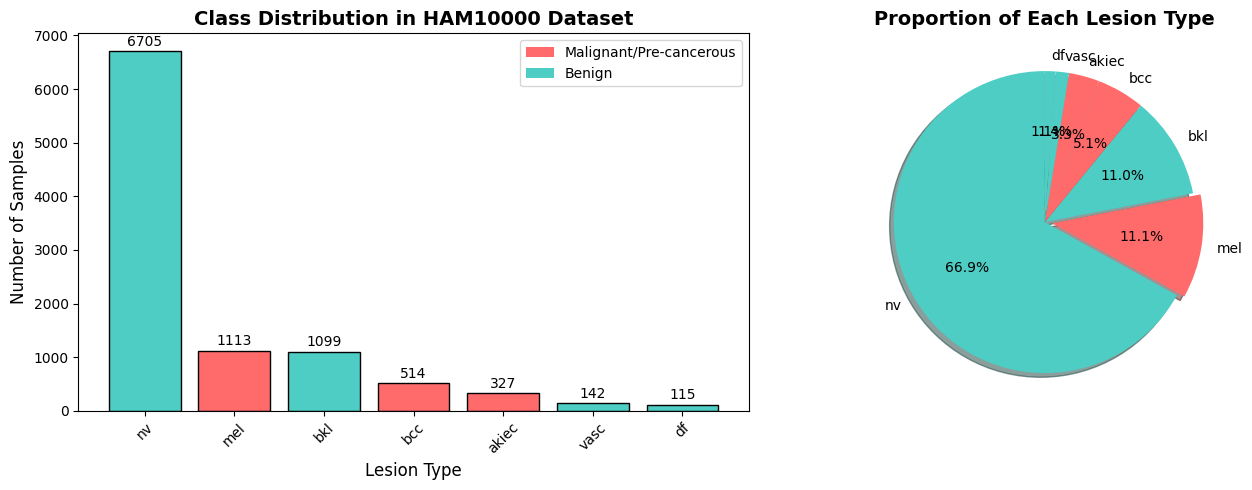

In [9]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
colors = ['#ff6b6b' if cls in MALIGNANT_CLASSES else '#4ecdc4' for cls in class_counts.index]
bars = axes[0].bar(class_counts.index, class_counts.values, color=colors, edgecolor='black')
axes[0].set_xlabel('Lesion Type', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Class Distribution in HAM10000 Dataset', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Add count labels on bars
for bar, count in zip(bars, class_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                str(count), ha='center', va='bottom', fontsize=10)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#ff6b6b', label='Malignant/Pre-cancerous'),
                   Patch(facecolor='#4ecdc4', label='Benign')]
axes[0].legend(handles=legend_elements, loc='upper right')

# Pie chart
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, explode=[0.05 if cls == 'mel' else 0 for cls in class_counts.index],
            shadow=True, startangle=90)
axes[1].set_title('Proportion of Each Lesion Type', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

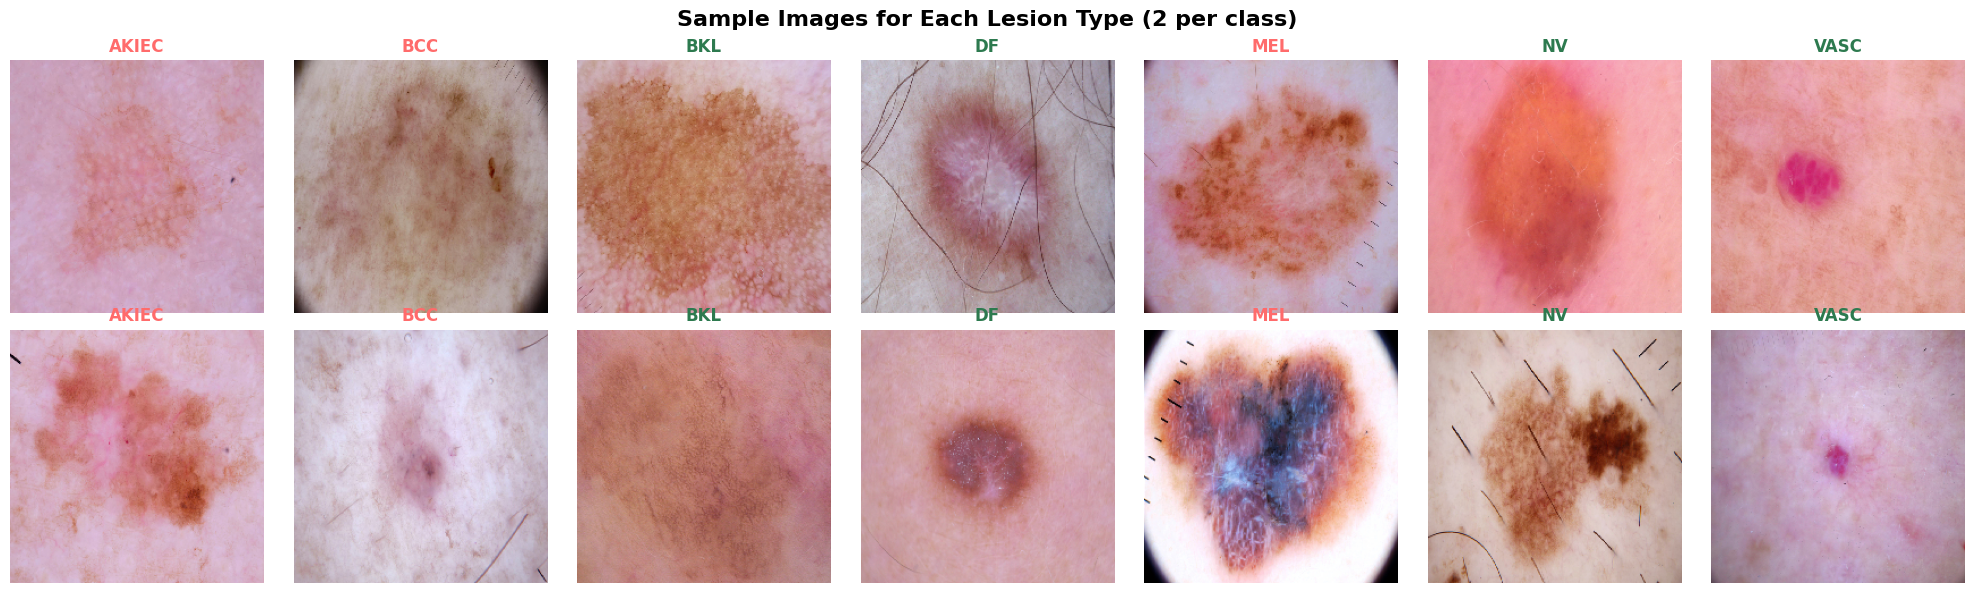

In [10]:
# Display sample images for each class
fig, axes = plt.subplots(2, 7, figsize=(20, 6))
fig.suptitle('Sample Images for Each Lesion Type (2 per class)', fontsize=16, fontweight='bold')

for idx, cls in enumerate(CLASS_NAMES):
    # Get 2 random samples from this class
    class_samples = df[df['dx'] == cls].sample(n=2, random_state=SEED)
    
    for row, (_, sample) in enumerate(class_samples.iterrows()):
        try:
            img = load_img(sample['image_path'], target_size=(IMAGE_SIZE, IMAGE_SIZE))
            axes[row, idx].imshow(img)
            
            # Color title based on malignancy
            title_color = '#ff6b6b' if cls in MALIGNANT_CLASSES else '#2d7a4f'
            axes[row, idx].set_title(f"{cls.upper()}", fontsize=12, fontweight='bold', color=title_color)
        except Exception as e:
            axes[row, idx].text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center')
            axes[row, idx].set_title(cls.upper(), fontsize=12)
        
        axes[row, idx].axis('off')

# Add class full names as subtitles
for idx, cls in enumerate(CLASS_NAMES):
    full_name = CLASS_FULL_NAMES[cls].split('(')[0].strip()
    axes[1, idx].set_xlabel(full_name, fontsize=9, labelpad=10)

plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Data Preprocessing and Augmentation Pipeline

We'll implement:
- Label encoding for the 7 classes
- Stratified train/validation/test split (70/15/15)
- `tf.data` pipelines for efficient data loading
- Data augmentation for the training set

In [11]:
# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['dx'])

# Verify encoding
print("Label Encoding Mapping:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  {cls} → {i}")

# ==============================================================================
# SPLIT POR LESION_ID - Evita data leakage
# ==============================================================================
# No HAM10000, múltiplas imagens podem ser da mesma lesão (mesmo lesion_id).
# Precisamos garantir que todas as imagens de uma lesão fiquem no mesmo split,
# caso contrário teremos data leakage (imagens similares em train e test).

print("\n📋 Corrigindo Data Leakage: Split por lesion_id")

# Obter lesion_ids únicos com seus labels
unique_lesions = df.groupby('lesion_id').agg({
    'dx': 'first',  # Pegar a classe (todas imagens da mesma lesão têm mesma classe)
    'label_encoded': 'first'
}).reset_index()

print(f"  Total de imagens: {len(df)}")
print(f"  Total de lesões únicas: {len(unique_lesions)}")

# Split por lesion_id (70/15/15)
lesion_ids = unique_lesions['lesion_id'].values
lesion_labels = unique_lesions['label_encoded'].values

# Primeiro split: 70% train, 30% temp
train_lesions, temp_lesions, _, temp_labels = train_test_split(
    lesion_ids, lesion_labels,
    test_size=0.30,
    stratify=lesion_labels,
    random_state=SEED
)

# Segundo split: 50% de temp para val, 50% para test
val_lesions, test_lesions, _, _ = train_test_split(
    temp_lesions, temp_labels,
    test_size=0.50,
    stratify=temp_labels,
    random_state=SEED
)

# Converter lesion_ids para sets para busca rápida
train_lesions_set = set(train_lesions)
val_lesions_set = set(val_lesions)
test_lesions_set = set(test_lesions)

# Filtrar imagens por lesion_id
train_mask = df['lesion_id'].isin(train_lesions_set)
val_mask = df['lesion_id'].isin(val_lesions_set)
test_mask = df['lesion_id'].isin(test_lesions_set)

# Extrair arrays de imagem e labels
X_train = df[train_mask]['image_path'].values
y_train = df[train_mask]['label_encoded'].values

X_val = df[val_mask]['image_path'].values
y_val = df[val_mask]['label_encoded'].values

X_test = df[test_mask]['image_path'].values
y_test = df[test_mask]['label_encoded'].values

print(f"\n✓ Data Split Complete (por lesion_id - SEM data leakage):")
print(f"  Training:   {len(X_train):5d} samples ({len(X_train)/len(df)*100:.1f}%) - {len(train_lesions)} lesões")
print(f"  Validation: {len(X_val):5d} samples ({len(X_val)/len(df)*100:.1f}%) - {len(val_lesions)} lesões")
print(f"  Test:       {len(X_test):5d} samples ({len(X_test)/len(df)*100:.1f}%) - {len(test_lesions)} lesões")
print(f"\n⚠️ Importante: Nenhuma lesão aparece em múltiplos splits!")

Label Encoding Mapping:
  akiec → 0
  bcc → 1
  bkl → 2
  df → 3
  mel → 4
  nv → 5
  vasc → 6

📋 Corrigindo Data Leakage: Split por lesion_id
  Total de imagens: 10015
  Total de lesões únicas: 7470

✓ Data Split Complete (por lesion_id - SEM data leakage):
  Training:    6981 samples (69.7%) - 5229 lesões
  Validation:  1532 samples (15.3%) - 1120 lesões
  Test:        1502 samples (15.0%) - 1121 lesões

⚠️ Importante: Nenhuma lesão aparece em múltiplos splits!


In [12]:
# Data augmentation layer for training (applied BEFORE preprocessing)
# Valores otimizados para imagens médicas dermatoscópicas
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.20),           # ±20% rotação (±72 graus) - lesões não têm orientação
    layers.RandomFlip("horizontal"),        # Flip horizontal
    layers.RandomFlip("vertical"),          # Flip vertical (válido para lesões)
    layers.RandomZoom((-0.15, 0.15)),      # ±15% zoom
    layers.RandomTranslation(0.15, 0.15),  # ±15% shift
    layers.RandomContrast(0.2),            # Variação de contraste ±20%
    layers.RandomBrightness(0.2),          # Variação de brilho ±20%
], name='data_augmentation')

print("✓ Augmentação melhorada:")
print("  - Rotação: ±72°")
print("  - Flip: horizontal + vertical")
print("  - Zoom: ±15%")
print("  - Translação: ±15%")
print("  - Contraste: ±20%")
print("  - Brilho: ±20%")

def load_and_preprocess_image(image_path, label):
    """Load image, resize, and preprocess for MobileNetV2."""
    # Read and decode image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Resize to target size
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    
    # Keep as float32 in [0, 255] range for augmentation
    img = tf.cast(img, tf.float32)
    
    # One-hot encode label
    label = tf.one_hot(label, NUM_CLASSES)
    
    return img, label

def apply_augmentation(images, labels):
    """Apply augmentation and then preprocess for MobileNetV2."""
    # Apply augmentation (expects [0, 255] range)
    images = data_augmentation(images, training=True)
    # Now preprocess for MobileNetV2 (scales to [-1, 1])
    images = preprocess_input(images)
    return images, labels

def apply_preprocessing_only(images, labels):
    """Just preprocess for MobileNetV2 without augmentation."""
    images = preprocess_input(images)
    return images, labels

def create_dataset(image_paths, labels, batch_size, augment=False, shuffle=True):
    """Create a tf.data.Dataset pipeline."""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths), seed=SEED)
    
    # Load and preprocess images (keeps [0, 255] range)
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    
    # Batch first
    dataset = dataset.batch(batch_size)
    
    # Apply augmentation OR just preprocessing
    if augment:
        dataset = dataset.map(apply_augmentation, num_parallel_calls=AUTOTUNE)
    else:
        dataset = dataset.map(apply_preprocessing_only, num_parallel_calls=AUTOTUNE)
    
    # Prefetch for performance (no cache to avoid memory issues with augmentation)
    dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

# Create datasets
train_dataset = create_dataset(X_train, y_train, BATCH_SIZE, augment=True, shuffle=True)
val_dataset = create_dataset(X_val, y_val, BATCH_SIZE, augment=False, shuffle=False)
test_dataset = create_dataset(X_test, y_test, BATCH_SIZE, augment=False, shuffle=False)

print("✓ tf.data pipelines created:")
print(f"  Training batches:   {len(train_dataset)}")
print(f"  Validation batches: {len(val_dataset)}")
print(f"  Test batches:       {len(test_dataset)}")

✓ Augmentação melhorada:
  - Rotação: ±72°
  - Flip: horizontal + vertical
  - Zoom: ±15%
  - Translação: ±15%
  - Contraste: ±20%
  - Brilho: ±20%
✓ tf.data pipelines created:
  Training batches:   219
  Validation batches: 48
  Test batches:       47
✓ tf.data pipelines created:
  Training batches:   219
  Validation batches: 48
  Test batches:       47


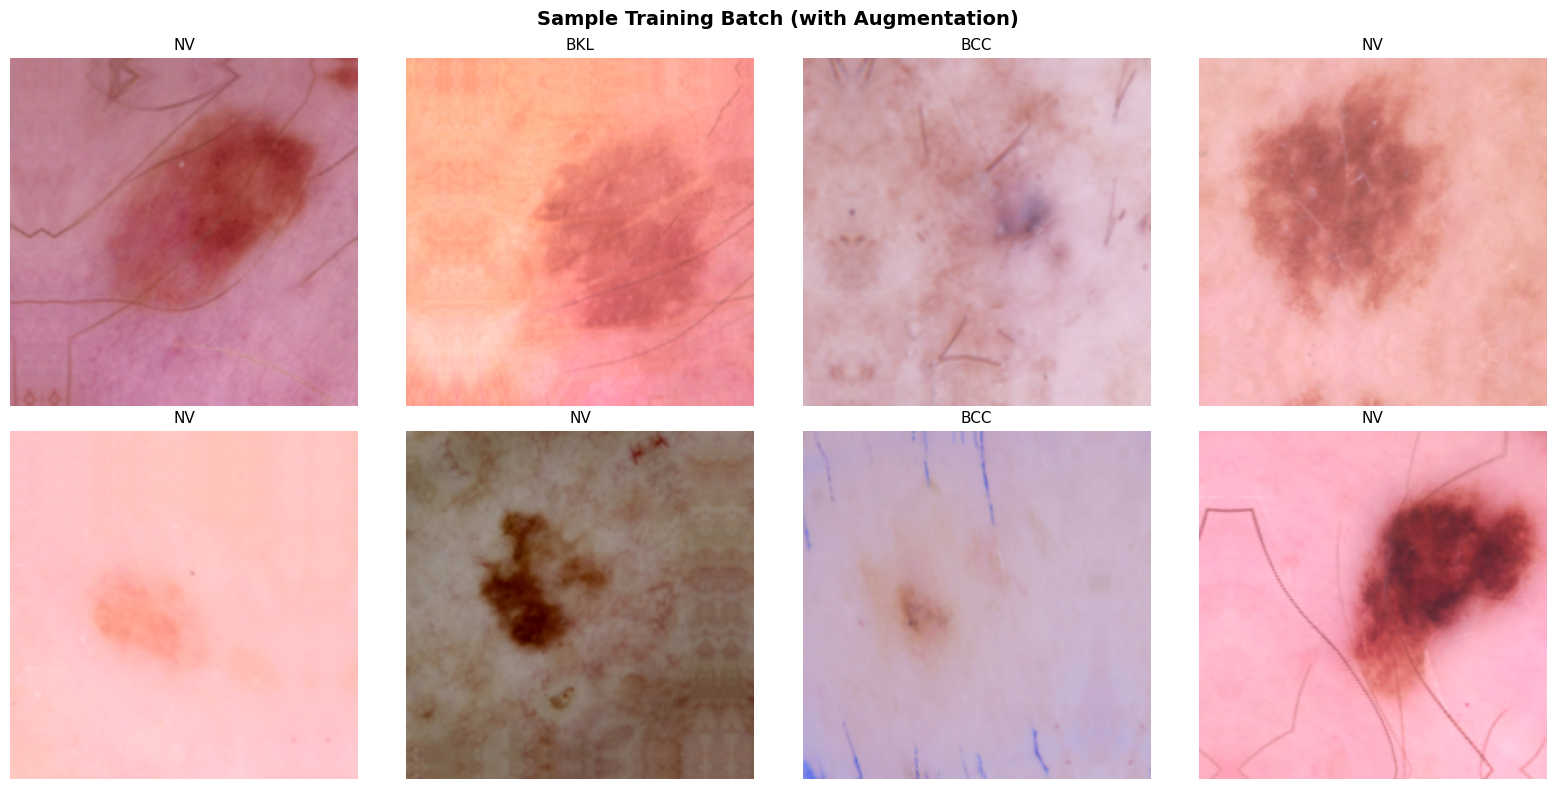

✓ Images should now display correctly with augmentation applied


In [13]:
# Visualize augmentation effects
sample_batch = next(iter(train_dataset.take(1)))
sample_images, sample_labels = sample_batch

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Training Batch (with Augmentation)', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    if i < len(sample_images):
        # Convert from MobileNetV2 preprocessing [-1, 1] back to [0, 1] for display
        img = sample_images[i].numpy()
        # Reverse MobileNetV2 preprocessing: was (x/127.5) - 1, so reverse is (x+1) * 127.5 / 255
        img = (img + 1.0) / 2.0  # Convert [-1, 1] to [0, 1]
        img = np.clip(img, 0, 1)  # Ensure valid range
        
        ax.imshow(img)
        
        label_idx = np.argmax(sample_labels[i])
        label_name = label_encoder.classes_[label_idx]
        ax.set_title(f'{label_name.upper()}', fontsize=11)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("✓ Images should now display correctly with augmentation applied")

## 5. Build MobileNetV2 Transfer Learning Model

We'll use MobileNetV2 pretrained on ImageNet as our base model, then add custom classification layers.

**Architecture:**
```
MobileNetV2 (frozen) → GlobalAveragePooling2D → Dropout(0.3) → Dense(256, ReLU) → Dropout(0.2) → Dense(7, Softmax)
```

In [14]:
def build_model(num_classes=NUM_CLASSES, fine_tune_at=None):
    """
    Build MobileNetV2-based classification model.
    
    Args:
        num_classes: Number of output classes
        fine_tune_at: If specified, unfreeze layers from this index onwards
        
    Returns:
        Compiled Keras model
    """
    # Load pretrained MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    # Build classification head
    model = models.Sequential([
        # Input layer
        layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        # Base model
        base_model,
        
        # Classification head
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ], name='SkinCancer_MobileNetV2')
    
    return model, base_model

# Build model
model, base_model = build_model()

# Display model architecture
print("=" * 60)
print("MODEL ARCHITECTURE")
print("=" * 60)
model.summary()

# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\n✓ Model built successfully")
print(f"  Total parameters:       {total_params:,}")
print(f"  Trainable parameters:   {trainable_params:,}")
print(f"  Non-trainable (frozen): {non_trainable_params:,}")

MODEL ARCHITECTURE
Model: "SkinCancer_MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d

## 6. Handle Class Imbalance with Class Weights

Given the severe class imbalance (~67% nv class), we'll compute class weights to give more importance to minority classes during training.

In [15]:
# ==============================================================================
# FOCAL LOSS - Melhora performance em datasets desbalanceados
# ==============================================================================

class FocalLoss(keras.losses.Loss):
    """
    Focal Loss para classificação multi-classe.
    
    Focal Loss foca em exemplos difíceis de classificar, reduzindo a 
    contribuição de exemplos fáceis. Particularmente útil para datasets
    desbalanceados como HAM10000.
    
    FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)
    
    Args:
        gamma: Fator de foco (padrão=2.0). Maior gamma = mais foco em exemplos difíceis.
        alpha: Peso por classe. Se None, usa pesos uniformes.
    """
    
    def __init__(self, gamma=2.0, alpha=None, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha
        
    def call(self, y_true, y_pred):
        # Clip para evitar log(0)
        y_pred = tf.clip_by_value(y_pred, keras.backend.epsilon(), 1 - keras.backend.epsilon())
        
        # Calcular cross-entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Calcular fator focal (1 - p_t)^gamma
        focal_weight = tf.pow(1 - y_pred, self.gamma)
        
        # Aplicar alpha se fornecido
        if self.alpha is not None:
            alpha_weight = y_true * self.alpha
            cross_entropy = alpha_weight * cross_entropy
        
        # Focal loss
        focal_loss = focal_weight * cross_entropy
        
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'gamma': self.gamma,
            'alpha': self.alpha
        })
        return config

print("✓ Focal Loss definida")
print("  - gamma=2.0 (fator de foco)")
print("  - Útil para classes desbalanceadas como HAM10000")

✓ Focal Loss definida
  - gamma=2.0 (fator de foco)
  - Útil para classes desbalanceadas como HAM10000


In [16]:
# Compute balanced class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary format for Keras
class_weights = dict(enumerate(class_weights_array))

# Display class weights
print("=" * 60)
print("COMPUTED CLASS WEIGHTS (Balanced)")
print("=" * 60)
print(f"{'Class':<8} {'Name':<30} {'Weight':>10} {'Samples':>10}")
print("-" * 60)

for class_idx, weight in class_weights.items():
    class_name = label_encoder.classes_[class_idx]
    full_name = CLASS_FULL_NAMES[class_name].split('(')[0].strip()
    sample_count = np.sum(y_train == class_idx)
    
    # Highlight high weights (minority classes)
    indicator = "⚠️" if weight > 2 else ""
    print(f"{class_name:<8} {full_name:<30} {weight:>10.4f} {sample_count:>10} {indicator}")

print("-" * 60)
print("\n⚠️ Higher weights for minority classes (df, vasc, akiec, mel)")
print("   This helps the model pay more attention to rare but important cases.")

COMPUTED CLASS WEIGHTS (Balanced)
Class    Name                               Weight    Samples
------------------------------------------------------------
akiec    Actinic Keratoses                  4.4923        222 ⚠️
bcc      Basal Cell Carcinoma               2.7626        361 ⚠️
bkl      Benign Keratosis                   1.2918        772 
df       Dermatofibroma                    14.0463         71 ⚠️
mel      Melanoma                           1.2901        773 
nv       Melanocytic Nevi                   0.2130       4683 
vasc     Vascular Lesions                  10.0736         99 ⚠️
------------------------------------------------------------

⚠️ Higher weights for minority classes (df, vasc, akiec, mel)
   This helps the model pay more attention to rare but important cases.


## 7. Train Model with Callbacks

Training strategy:
1. **Phase 1:** Train only classification head (frozen base) for 10 epochs
2. **Phase 2:** Fine-tune last 50 layers of MobileNetV2 with lower learning rate for 20 epochs

In [17]:
# Define callbacks
model_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=1
    )
]

# Compile model for Phase 1 (frozen base) with Focal Loss
# Usar Focal Loss em vez de categorical_crossentropy para lidar melhor com desbalanceamento
focal_loss = FocalLoss(gamma=2.0)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss,
    metrics=['accuracy', keras.metrics.AUC(name='auc', multi_label=True)]
)

print("✓ Model compiled for Phase 1 training")
print("  Optimizer: Adam (lr=1e-4)")
print("  Loss: Categorical Crossentropy")
print("  Metrics: Accuracy")

✓ Model compiled for Phase 1 training
  Optimizer: Adam (lr=1e-4)
  Loss: Categorical Crossentropy
  Metrics: Accuracy


In [18]:
# Phase 1: Train with frozen base
print("=" * 60)
print("PHASE 1: Training Classification Head (Frozen Base)")
print("=" * 60)

PHASE1_EPOCHS = 10

history_phase1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=PHASE1_EPOCHS,
    class_weight=class_weights,
    callbacks=model_callbacks,
    verbose=1
)

print("\n✓ Phase 1 training complete")

PHASE 1: Training Classification Head (Frozen Base)
Epoch 1/10
Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 4.6859 - accuracy: 0.6068 - auc: 0.6556
Epoch 1: val_accuracy improved from -inf to 0.68342, saving model to best_model.keras

Epoch 1: val_accuracy improved from -inf to 0.68342, saving model to best_model.keras
219/219 [==============================] - 47s 184ms/step - loss: 4.6859 - accuracy: 0.6068 - auc: 0.6556 - val_loss: 3.9590 - val_accuracy: 0.6834 - val_auc: 0.8255 - lr: 1.0000e-04
Epoch 2/10
Epoch 2/10
218/219 [============================>.] - ETA: 0s - loss: 3.6803 - accuracy: 0.6677 - auc: 0.7863
Epoch 2: val_accuracy improved from 0.68342 to 0.71084, saving model to best_model.keras

Epoch 2: val_accuracy improved from 0.68342 to 0.71084, saving model to best_model.keras
219/219 [==============================] - 35s 154ms/step - loss: 3.6798 - accuracy: 0.6677 - auc: 0.7864 - val_loss: 3.2434 - val_accuracy: 0.7108 - val_auc: 0.8630 - lr:

In [20]:
# Phase 2: Fine-tune last 50 layers
print("=" * 60)
print("PHASE 2: Fine-tuning Last 50 Layers")
print("=" * 60)

# ============================================================================
# CARREGAR O MELHOR MODELO DA PHASE 1 ANTES DE CONTINUAR
# ============================================================================
from tensorflow.keras.models import load_model

# Carregar o melhor modelo salvo pelo ModelCheckpoint
print("📥 Carregando melhor modelo da Phase 1...")
best_model_path = 'best_model.keras'

# Recriar o modelo base para manter a referência
model, base_model = build_model()

# Carregar os pesos do melhor modelo
try:
    # Carregar modelo com custom loss
    loaded_model = load_model(best_model_path, custom_objects={'FocalLoss': FocalLoss})
    model.set_weights(loaded_model.get_weights())
    print(f"✓ Pesos carregados de '{best_model_path}'")
    
    # Recompilar para verificar performance (com mesmas métricas da Phase 1)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss=FocalLoss(gamma=2.0),
        metrics=['accuracy', keras.metrics.AUC(name='auc', multi_label=True)]
    )
    
    # Verificar performance antes de fine-tuning
    print("\n📊 Verificando performance do modelo carregado...")
    val_results = model.evaluate(val_dataset, verbose=0)
    print(f"  Validation Loss: {val_results[0]:.4f}")
    print(f"  Validation Accuracy: {val_results[1]:.4f}")
    print(f"  Validation AUC: {val_results[2]:.4f}")
except Exception as e:
    print(f"⚠ Erro ao carregar modelo: {e}")
    print("  Continuando com pesos atuais...")

# Unfreeze the base model
base_model.trainable = True

# Freeze all layers except the last 50
FINE_TUNE_AT = len(base_model.layers) - 50
for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

# Count trainable parameters after unfreezing
trainable_count = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"\n✓ Unfroze layers from index {FINE_TUNE_AT} onwards")
print(f"  Trainable parameters now: {trainable_count:,}")

# ============================================================================
# RECOMPILAR COM A MESMA LOSS (Focal Loss) PARA CONSISTÊNCIA
# ============================================================================
focal_loss_phase2 = FocalLoss(gamma=2.0)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Learning rate menor
    loss=focal_loss_phase2,  # Mesma loss da Phase 1!
    metrics=['accuracy', keras.metrics.AUC(name='auc', multi_label=True)]  # Mesmas métricas!
)

print("✓ Recompiled with lower learning rate (1e-5)")
print("  Loss: Focal Loss (consistente com Phase 1)")
print("  Metrics: Accuracy, AUC")

# ============================================================================
# ATUALIZAR CALLBACKS PARA PHASE 2
# ============================================================================
phase2_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_auc',  # Monitorar AUC em vez de loss
        patience=10,
        restore_best_weights=True,
        mode='max',  # AUC deve ser maximizado
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_auc',  # Consistente com EarlyStopping
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=1
    )
]

# Continue training
PHASE2_EPOCHS = 20

history_phase2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=PHASE1_EPOCHS + PHASE2_EPOCHS,
    initial_epoch=PHASE1_EPOCHS,
    class_weight=class_weights,
    callbacks=phase2_callbacks,  # Usar callbacks atualizados
    verbose=1
)

print("\n✓ Phase 2 fine-tuning complete")

PHASE 2: Fine-tuning Last 50 Layers
📥 Carregando melhor modelo da Phase 1...
✓ Pesos carregados de 'best_model.keras'

📊 Verificando performance do modelo carregado...
✓ Pesos carregados de 'best_model.keras'

📊 Verificando performance do modelo carregado...
  Validation Loss: 1.2497
  Validation Accuracy: 0.7402
  Validation AUC: 0.8900

✓ Unfroze layers from index 104 onwards
  Trainable parameters now: 2,184,839
✓ Recompiled with lower learning rate (1e-5)
  Loss: Focal Loss (consistente com Phase 1)
  Metrics: Accuracy, AUC
  Validation Loss: 1.2497
  Validation Accuracy: 0.7402
  Validation AUC: 0.8900

✓ Unfroze layers from index 104 onwards
  Trainable parameters now: 2,184,839
✓ Recompiled with lower learning rate (1e-5)
  Loss: Focal Loss (consistente com Phase 1)
  Metrics: Accuracy, AUC
Epoch 11/30
Epoch 11/30
218/219 [============================>.] - ETA: 0s - loss: 1.3636 - accuracy: 0.6904 - auc: 0.8364
Epoch 11: val_auc improved from -inf to 0.89293, saving model to bes

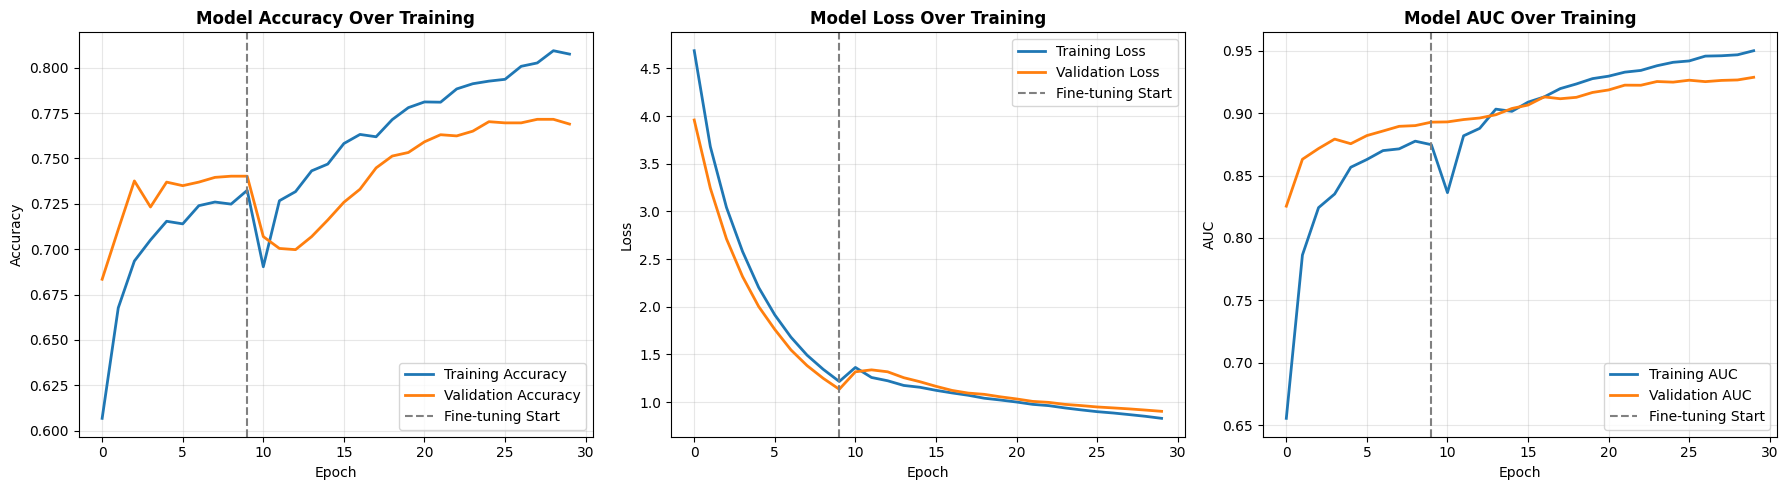


✓ Training Complete
  Best Validation Accuracy: 0.7715
  Best Validation Loss:     0.9031
  Best Validation AUC:      0.9286


In [21]:
# Combine training histories
def combine_histories(h1, h2):
    """Combine two training history objects."""
    combined = {}
    
    # Pegar todas as chaves de ambos os históricos
    all_keys = set(h1.history.keys()) | set(h2.history.keys())
    
    for key in all_keys:
        if key in h1.history and key in h2.history:
            combined[key] = h1.history[key] + h2.history[key]
        elif key in h1.history:
            # Preencher Phase 2 com None
            combined[key] = h1.history[key] + [None] * len(list(h2.history.values())[0])
        else:
            # Preencher Phase 1 com None
            combined[key] = [None] * len(list(h1.history.values())[0]) + h2.history[key]
    
    return combined

history = combine_histories(history_phase1, history_phase2)

# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].plot(history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].axvline(x=PHASE1_EPOCHS-1, color='gray', linestyle='--', label='Fine-tuning Start')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Over Training', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].axvline(x=PHASE1_EPOCHS-1, color='gray', linestyle='--', label='Fine-tuning Start')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss Over Training', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# AUC
if 'auc' in history and 'val_auc' in history:
    # Filtrar None values para plotar
    auc_train = [v for v in history['auc'] if v is not None]
    auc_val = [v for v in history['val_auc'] if v is not None]
    epochs_auc = list(range(len(auc_train)))
    
    axes[2].plot(epochs_auc, auc_train, label='Training AUC', linewidth=2)
    axes[2].plot(epochs_auc, auc_val, label='Validation AUC', linewidth=2)
    axes[2].axvline(x=PHASE1_EPOCHS-1, color='gray', linestyle='--', label='Fine-tuning Start')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].set_title('Model AUC Over Training', fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Print best metrics
best_val_acc = max([v for v in history['val_accuracy'] if v is not None])
best_val_loss = min([v for v in history['val_loss'] if v is not None])
best_val_auc = max([v for v in history.get('val_auc', [0]) if v is not None])

print(f"\n✓ Training Complete")
print(f"  Best Validation Accuracy: {best_val_acc:.4f}")
print(f"  Best Validation Loss:     {best_val_loss:.4f}")
print(f"  Best Validation AUC:      {best_val_auc:.4f}")

## 8. Otimização de Thresholds com Youden's J Index

Em vez de usar thresholds fixos de 0.5 para todas as classes, utilizamos o **Youden's J Index** (J = Sensibilidade + Especificidade - 1) para encontrar o threshold ótimo para cada classe.

Esta abordagem é:
- **Mais simples** que RL (PPO), sem necessidade de treinamento adicional
- **Matematicamente fundamentada** - Youden's J maximiza a distância da curva ROC à linha diagonal
- **Clinicamente relevante** - Balanceia sensibilidade e especificidade

Para melanoma, usamos um **ajuste de segurança** que favorece maior sensibilidade (menos falsos negativos).

In [22]:
def find_optimal_thresholds_youden(y_true, y_pred_proba, class_names, melanoma_idx=None, melanoma_safety_margin=0.1):
    """
    Encontra thresholds ótimos por classe usando Youden's J Index.
    
    Youden's J = Sensibilidade + Especificidade - 1
    
    O threshold ótimo é o ponto na curva ROC mais distante da linha diagonal.
    
    Args:
        y_true: Labels verdadeiros (one-hot ou inteiros)
        y_pred_proba: Probabilidades previstas (n_samples, n_classes)
        class_names: Lista de nomes das classes
        melanoma_idx: Índice da classe melanoma para ajuste de segurança
        melanoma_safety_margin: Margem de segurança para melanoma (reduz threshold)
        
    Returns:
        optimal_thresholds: Array de thresholds ótimos por classe
        threshold_info: Dict com informações detalhadas
    """
    from sklearn.metrics import roc_curve
    
    n_classes = len(class_names)
    optimal_thresholds = np.zeros(n_classes)
    threshold_info = {}
    
    # Converter y_true para formato binário se necessário
    if len(y_true.shape) == 1:
        y_true_bin = np.eye(n_classes)[y_true]
    else:
        y_true_bin = y_true
    
    print("=" * 70)
    print("OTIMIZAÇÃO DE THRESHOLDS COM YOUDEN'S J INDEX")
    print("=" * 70)
    print(f"{'Classe':<10} {'Threshold':<12} {'Sensibilidade':<15} {'Especificidade':<15} {'Youden J':<10}")
    print("-" * 70)
    
    for i, class_name in enumerate(class_names):
        # Calcular curva ROC para esta classe (one-vs-rest)
        fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        
        # Calcular Youden's J para cada threshold
        # J = TPR - FPR = Sensibilidade + Especificidade - 1
        youden_j = tpr - fpr
        
        # Encontrar threshold que maximiza Youden's J
        best_idx = np.argmax(youden_j)
        best_threshold = thresholds[best_idx]
        best_tpr = tpr[best_idx]  # Sensibilidade
        best_tnr = 1 - fpr[best_idx]  # Especificidade
        best_youden = youden_j[best_idx]
        
        # Ajuste de segurança para melanoma (reduzir threshold = mais sensibilidade)
        if melanoma_idx is not None and i == melanoma_idx:
            original = best_threshold
            best_threshold = max(0.05, best_threshold - melanoma_safety_margin)
            marker = " 🎯 (ajustado)"
        else:
            marker = ""
        
        # Clamp threshold entre 0.05 e 0.95
        best_threshold = np.clip(best_threshold, 0.05, 0.95)
        
        optimal_thresholds[i] = best_threshold
        threshold_info[class_name] = {
            'threshold': best_threshold,
            'sensitivity': best_tpr,
            'specificity': best_tnr,
            'youden_j': best_youden
        }
        
        print(f"{class_name:<10} {best_threshold:<12.4f} {best_tpr:<15.4f} {best_tnr:<15.4f} {best_youden:<10.4f}{marker}")
    
    print("-" * 70)
    print("🎯 Melanoma: threshold reduzido para maior sensibilidade (segurança clínica)")
    
    return optimal_thresholds, threshold_info

print("✓ Função find_optimal_thresholds_youden definida")
print("  - Usa Youden's J Index (Sensibilidade + Especificidade - 1)")
print("  - Aplica margem de segurança para melanoma")

✓ Função find_optimal_thresholds_youden definida
  - Usa Youden's J Index (Sensibilidade + Especificidade - 1)
  - Aplica margem de segurança para melanoma


## 9. Calcular Thresholds Ótimos

Usamos o conjunto de validação para calcular os thresholds ótimos, que serão aplicados ao conjunto de teste.

In [23]:
# Get model predictions on validation set
print("Getting validation set predictions for threshold optimization...")

# Predict probabilities
val_predictions = model.predict(val_dataset, verbose=1)

# Get true labels (need to reconstruct from one-hot)
val_true_labels = []
for _, labels in val_dataset:
    val_true_labels.extend(np.argmax(labels.numpy(), axis=1))
val_true_labels = np.array(val_true_labels)

# Verify shapes
print(f"\n✓ Validation predictions shape: {val_predictions.shape}")
print(f"✓ Validation labels shape: {val_true_labels.shape}")

# Find melanoma class index
melanoma_idx = list(label_encoder.classes_).index('mel')
print(f"✓ Melanoma class index: {melanoma_idx}")

Getting validation set predictions for threshold optimization...
48/48 [==============================] - 4s 66ms/step

✓ Validation predictions shape: (1532, 7)
✓ Validation labels shape: (1532,)
✓ Melanoma class index: 4

✓ Validation predictions shape: (1532, 7)
✓ Validation labels shape: (1532,)
✓ Melanoma class index: 4


In [24]:
# Calcular thresholds ótimos usando Youden's J Index
optimized_thresholds, threshold_info = find_optimal_thresholds_youden(
    y_true=val_true_labels,
    y_pred_proba=val_predictions,
    class_names=list(label_encoder.classes_),
    melanoma_idx=melanoma_idx,
    melanoma_safety_margin=0.1  # Reduz threshold do melanoma para maior sensibilidade
)

# Salvar thresholds
np.save('optimized_thresholds.npy', optimized_thresholds)
print("\n✓ Thresholds ótimos calculados e salvos em 'optimized_thresholds.npy'")

OTIMIZAÇÃO DE THRESHOLDS COM YOUDEN'S J INDEX
Classe     Threshold    Sensibilidade   Especificidade  Youden J  
----------------------------------------------------------------------
akiec      0.0500       0.9811          0.8391          0.8202    
bcc        0.0500       0.9390          0.8828          0.8218    
bkl        0.2169       0.8187          0.8280          0.6467    
df         0.0500       0.9167          0.8050          0.7217    
mel        0.1039       0.8786          0.7601          0.6387     🎯 (ajustado)
nv         0.5174       0.8576          0.8560          0.7136    
vasc       0.1581       0.8636          0.9907          0.8544    
----------------------------------------------------------------------
🎯 Melanoma: threshold reduzido para maior sensibilidade (segurança clínica)

✓ Thresholds ótimos calculados e salvos em 'optimized_thresholds.npy'


## 10. Avaliar Modelo com Thresholds Otimizados

Comparamos a performance do modelo com thresholds padrão (argmax) vs. thresholds otimizados por Youden's J.

In [25]:
# Get predictions on test set
print("Evaluating on test set...")
test_predictions = model.predict(test_dataset, verbose=1)

# Get true labels
test_true_labels = []
for _, labels in test_dataset:
    test_true_labels.extend(np.argmax(labels.numpy(), axis=1))
test_true_labels = np.array(test_true_labels)

print(f"✓ Test predictions shape: {test_predictions.shape}")
print(f"✓ Test labels shape: {test_true_labels.shape}")

Evaluating on test set...
47/47 [==============================] - 4s 85ms/step
✓ Test predictions shape: (1502, 7)
✓ Test labels shape: (1502,)
✓ Test predictions shape: (1502, 7)
✓ Test labels shape: (1502,)


In [26]:
def apply_thresholds(predictions, thresholds):
    """Apply per-class thresholds to probability predictions."""
    results = []
    threshold_used = []
    
    for probs in predictions:
        # Check if any class exceeds its threshold
        above_threshold = probs >= thresholds
        
        if np.any(above_threshold):
            # Among classes above threshold, pick highest probability
            masked_probs = np.where(above_threshold, probs, -1)
            pred = np.argmax(masked_probs)
            threshold_used.append(True)
        else:
            # Fallback to argmax
            pred = np.argmax(probs)
            threshold_used.append(False)
        
        results.append(pred)
    
    return np.array(results), threshold_used

# Standard predictions (argmax)
y_pred_standard = np.argmax(test_predictions, axis=1)

# Predictions with optimized thresholds
y_pred_optimized, threshold_used = apply_thresholds(test_predictions, optimized_thresholds)

print(f"✓ Standard predictions (argmax): {len(y_pred_standard)}")
print(f"✓ Optimized predictions (RL thresholds): {len(y_pred_optimized)}")
print(f"  Threshold applied: {sum(threshold_used)} / {len(threshold_used)} samples")

✓ Standard predictions (argmax): 1502
✓ Optimized predictions (RL thresholds): 1502
  Threshold applied: 1502 / 1502 samples


In [27]:
# Compare metrics
def compute_metrics(y_true, y_pred, name=""):
    """Compute and display classification metrics."""
    acc = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Melanoma-specific recall (sensitivity)
    mel_idx = list(label_encoder.classes_).index('mel')
    mel_mask = y_true == mel_idx
    mel_sensitivity = recall_score(y_true[mel_mask], y_pred[mel_mask], 
                                   average='micro', zero_division=0) if mel_mask.sum() > 0 else 0
    
    metrics = {
        'accuracy': acc,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'melanoma_sensitivity': mel_sensitivity
    }
    
    return metrics

# Compute metrics for both methods
metrics_standard = compute_metrics(test_true_labels, y_pred_standard, "Standard")
metrics_optimized = compute_metrics(test_true_labels, y_pred_optimized, "RL-Optimized")

# Display comparison
print("=" * 70)
print("PERFORMANCE COMPARISON: Standard vs RL-Optimized Thresholds")
print("=" * 70)
print(f"{'Metric':<25} {'Standard (argmax)':<20} {'RL-Optimized':<20} {'Δ':<10}")
print("-" * 70)

for metric in metrics_standard.keys():
    std_val = metrics_standard[metric]
    opt_val = metrics_optimized[metric]
    delta = opt_val - std_val
    
    # Highlight melanoma sensitivity
    marker = "🎯" if 'melanoma' in metric else ""
    delta_str = f"{delta:+.4f}" if delta != 0 else "0.0000"
    color_indicator = "↑" if delta > 0 else ("↓" if delta < 0 else "=")
    
    print(f"{metric:<25} {std_val:<20.4f} {opt_val:<20.4f} {delta_str} {color_indicator} {marker}")

print("-" * 70)

PERFORMANCE COMPARISON: Standard vs RL-Optimized Thresholds
Metric                    Standard (argmax)    RL-Optimized         Δ         
----------------------------------------------------------------------
accuracy                  0.7656               0.7337               -0.0320 ↓ 
precision_macro           0.5790               0.5364               -0.0426 ↓ 
precision_weighted        0.7540               0.7650               +0.0110 ↑ 
recall_macro              0.5127               0.5495               +0.0368 ↑ 
recall_weighted           0.7656               0.7337               -0.0320 ↓ 
f1_macro                  0.5303               0.5241               -0.0062 ↓ 
f1_weighted               0.7525               0.7435               -0.0091 ↓ 
melanoma_sensitivity      0.2994               0.4251               +0.1257 ↑ 🎯
----------------------------------------------------------------------


In [29]:
# Detailed classification report with RL thresholds
print("=" * 70)
print("DETAILED CLASSIFICATION REPORT (RL-Optimized Thresholds)")
print("=" * 70)

target_names = [f"{cls} ({CLASS_FULL_NAMES[cls].split('(')[0].strip()})" 
                for cls in label_encoder.classes_]

print(classification_report(
    test_true_labels, 
    y_pred_optimized, 
    target_names=target_names,
    digits=4
))

DETAILED CLASSIFICATION REPORT (RL-Optimized Thresholds)
                            precision    recall  f1-score   support

 akiec (Actinic Keratoses)     0.5000    0.2308    0.3158        52
bcc (Basal Cell Carcinoma)     0.6780    0.5634    0.6154        71
    bkl (Benign Keratosis)     0.4032    0.6108    0.4857       167
       df (Dermatofibroma)     0.2222    0.5000    0.3077        20
            mel (Melanoma)     0.4277    0.4251    0.4264       167
     nv (Melanocytic Nevi)     0.9152    0.8496    0.8812      1004
   vasc (Vascular Lesions)     0.6087    0.6667    0.6364        21

                  accuracy                         0.7337      1502
                 macro avg     0.5364    0.5495    0.5241      1502
              weighted avg     0.7650    0.7337    0.7435      1502



In [32]:
# Analyze common misclassifications
print("=" * 60)
print("MISCLASSIFICATION ANALYSIS")
print("=" * 60)

# Find most common errors
cm = cm_optimized.copy()
np.fill_diagonal(cm, 0)  # Remove correct predictions

# Get top misclassifications
misclass = []
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i != j and cm[i, j] > 0:
            misclass.append({
                'true': label_encoder.classes_[i],
                'pred': label_encoder.classes_[j],
                'count': cm[i, j],
                'severity': 'HIGH' if label_encoder.classes_[i] in MALIGNANT_CLASSES else 'LOW'
            })

# Sort by count and display top misclassifications
misclass_df = pd.DataFrame(misclass).sort_values('count', ascending=False)

print(f"\nTop 10 Most Common Misclassifications:")
print("-" * 60)
print(f"{'True Class':<12} {'Predicted':<12} {'Count':<8} {'Clinical Severity'}")
print("-" * 60)

for _, row in misclass_df.head(10).iterrows():
    severity_marker = "⚠️ CRITICAL" if row['true'] == 'mel' and row['pred'] in BENIGN_CLASSES else ""
    print(f"{row['true']:<12} {row['pred']:<12} {row['count']:<8} {row['severity']} {severity_marker}")

print("-" * 60)
print("\n⚠️ CRITICAL: Melanoma misclassified as benign = potentially life-threatening")

MISCLASSIFICATION ANALYSIS

Top 10 Most Common Misclassifications:
------------------------------------------------------------
True Class   Predicted    Count    Clinical Severity
------------------------------------------------------------
nv           bkl          67       LOW 
nv           mel          53       LOW 
mel          nv           47       HIGH ⚠️ CRITICAL
mel          bkl          38       HIGH ⚠️ CRITICAL
akiec        bkl          29       HIGH 
bkl          nv           24       LOW 
bkl          mel          23       LOW 
nv           df           18       LOW 
bcc          bkl          12       HIGH 
nv           bcc          9        LOW 
------------------------------------------------------------

⚠️ CRITICAL: Melanoma misclassified as benign = potentially life-threatening


## 12. Create Inference Function for Deployment

A complete inference function that:
1. Loads and preprocesses a single image
2. Gets model predictions
3. Applies RL-optimized thresholds
4. Returns clinical interpretation

In [33]:
def predict_image(image_path, model, thresholds, class_names, return_visualization=False):
    """
    Perform inference on a single skin lesion image.
    
    Args:
        image_path: Path to the image file
        model: Trained Keras model
        thresholds: RL-optimized per-class thresholds (numpy array)
        class_names: List of class names
        return_visualization: If True, returns a matplotlib figure
        
    Returns:
        Dictionary with prediction results and clinical interpretation
    """
    # Load and preprocess image
    img = load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = img_to_array(img)
    img_preprocessed = preprocess_input(img_array)
    img_batch = np.expand_dims(img_preprocessed, axis=0)
    
    # Get predictions
    probabilities = model.predict(img_batch, verbose=0)[0]
    
    # Apply thresholds
    above_threshold = probabilities >= thresholds
    
    if np.any(above_threshold):
        # Pick class with highest probability among those above threshold
        masked_probs = np.where(above_threshold, probabilities, -1)
        predicted_idx = np.argmax(masked_probs)
        threshold_used = True
    else:
        # Fallback to argmax
        predicted_idx = np.argmax(probabilities)
        threshold_used = False
    
    predicted_class = class_names[predicted_idx]
    confidence = probabilities[predicted_idx]
    
    # Clinical interpretation
    if predicted_class in MALIGNANT_CLASSES:
        clinical_category = "POTENTIALLY MALIGNANT"
        recommendation = "⚠️ URGENT: Recommend immediate dermatologist consultation"
        risk_level = "HIGH"
    else:
        clinical_category = "LIKELY BENIGN"
        recommendation = "✓ Monitor for changes. Consult dermatologist if concerned."
        risk_level = "LOW"
    
    result = {
        'image_path': str(image_path),
        'predicted_class': predicted_class,
        'predicted_class_full': CLASS_FULL_NAMES.get(predicted_class, predicted_class),
        'confidence': float(confidence),
        'threshold_used': threshold_used,
        'class_threshold': float(thresholds[predicted_idx]),
        'all_probabilities': {name: float(prob) for name, prob in zip(class_names, probabilities)},
        'clinical_category': clinical_category,
        'recommendation': recommendation,
        'risk_level': risk_level
    }
    
    if return_visualization:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Display image
        axes[0].imshow(img)
        title_color = '#ff6b6b' if predicted_class in MALIGNANT_CLASSES else '#2d7a4f'
        axes[0].set_title(f"Prediction: {predicted_class.upper()}\n({confidence*100:.1f}% confidence)", 
                         fontsize=14, fontweight='bold', color=title_color)
        axes[0].axis('off')
        
        # Probability bar chart
        colors = ['#ff6b6b' if cls in MALIGNANT_CLASSES else '#4ecdc4' for cls in class_names]
        bars = axes[1].barh(class_names, probabilities, color=colors, edgecolor='black')
        
        # Add threshold lines
        for i, (thresh, cls) in enumerate(zip(thresholds, class_names)):
            axes[1].axvline(x=thresh, ymin=i/7, ymax=(i+1)/7, color='red', linestyle='--', alpha=0.7)
        
        axes[1].set_xlabel('Probability', fontsize=12)
        axes[1].set_title('Class Probabilities\n(Red dashed = threshold)', fontsize=12)
        axes[1].set_xlim(0, 1)
        
        plt.tight_layout()
        result['figure'] = fig
    
    return result

print("✓ predict_image() function defined")

✓ predict_image() function defined


INFERENCE DEMONSTRATION

SAMPLE 1
True Label:        NV
Predicted:         NV
Confidence:        91.34%
Threshold Used:    True
Class Threshold:   0.517

Clinical Category: LIKELY BENIGN
Risk Level:        LOW
Recommendation:    ✓ Monitor for changes. Consult dermatologist if concerned.

Result: ✓ CORRECT

SAMPLE 1
True Label:        NV
Predicted:         NV
Confidence:        91.34%
Threshold Used:    True
Class Threshold:   0.517

Clinical Category: LIKELY BENIGN
Risk Level:        LOW
Recommendation:    ✓ Monitor for changes. Consult dermatologist if concerned.

Result: ✓ CORRECT


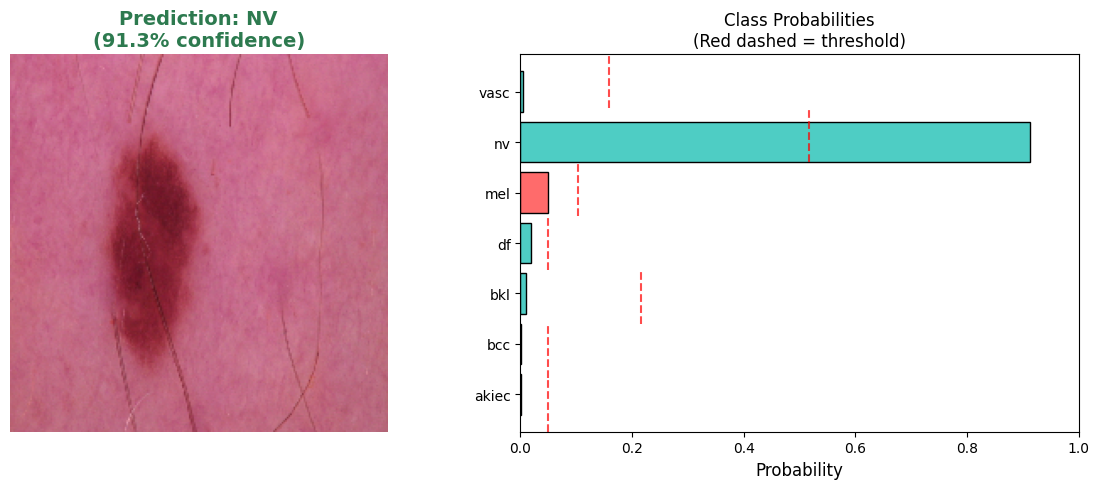


SAMPLE 2
True Label:        NV
Predicted:         NV
Confidence:        69.41%
Threshold Used:    True
Class Threshold:   0.517

Clinical Category: LIKELY BENIGN
Risk Level:        LOW
Recommendation:    ✓ Monitor for changes. Consult dermatologist if concerned.

Result: ✓ CORRECT


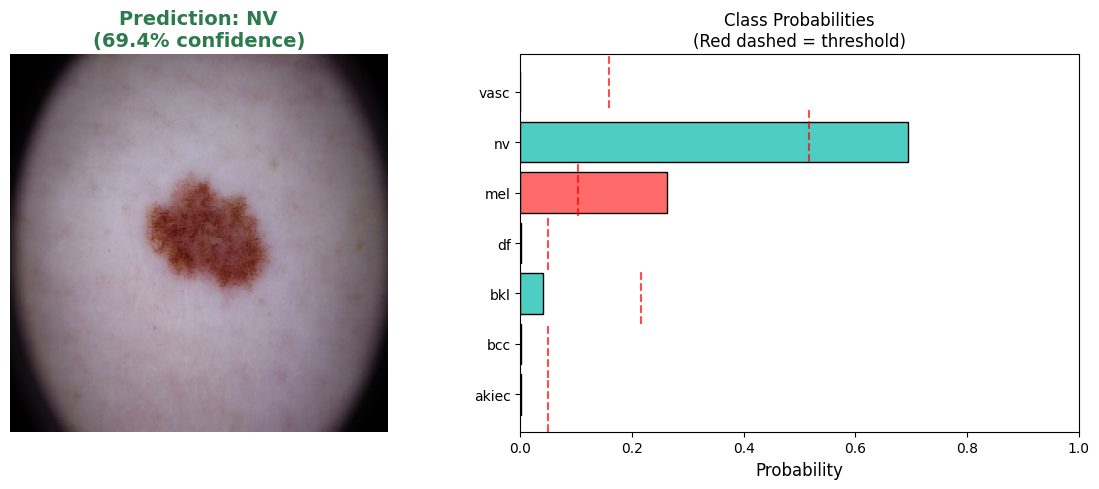


SAMPLE 3
True Label:        BCC
Predicted:         BCC
Confidence:        43.48%
Threshold Used:    True
Class Threshold:   0.050

Clinical Category: POTENTIALLY MALIGNANT
Risk Level:        HIGH
Recommendation:    ⚠️ URGENT: Recommend immediate dermatologist consultation

Result: ✓ CORRECT


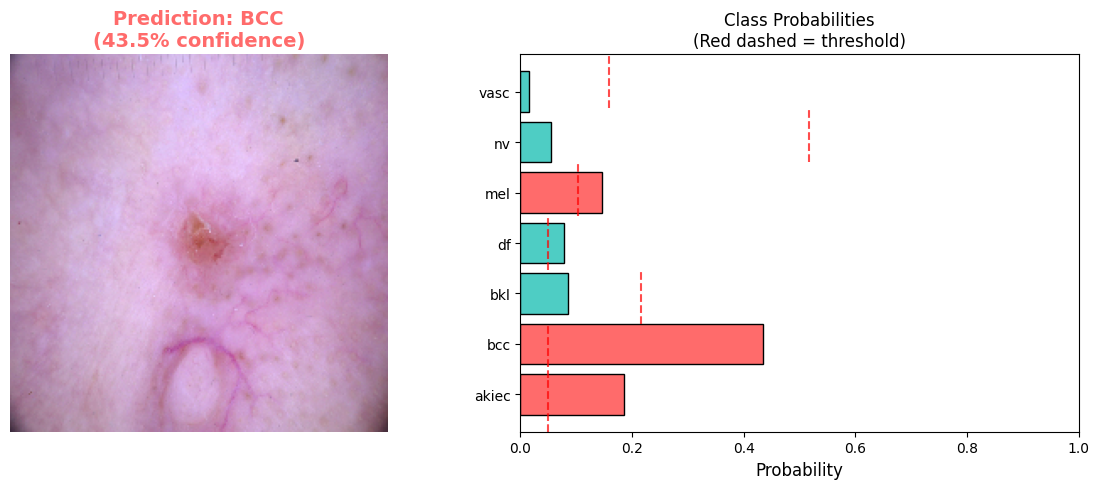

In [34]:
# Demonstrate inference on sample test images
print("=" * 70)
print("INFERENCE DEMONSTRATION")
print("=" * 70)

# Get a few sample images from test set
sample_indices = np.random.choice(len(X_test), size=3, replace=False)

for i, idx in enumerate(sample_indices):
    image_path = X_test[idx]
    true_label = label_encoder.classes_[y_test[idx]]
    
    # Run inference
    result = predict_image(
        image_path=image_path,
        model=model,
        thresholds=optimized_thresholds,
        class_names=list(label_encoder.classes_),
        return_visualization=True
    )
    
    print(f"\n{'='*70}")
    print(f"SAMPLE {i+1}")
    print(f"{'='*70}")
    print(f"True Label:        {true_label.upper()}")
    print(f"Predicted:         {result['predicted_class'].upper()}")
    print(f"Confidence:        {result['confidence']*100:.2f}%")
    print(f"Threshold Used:    {result['threshold_used']}")
    print(f"Class Threshold:   {result['class_threshold']:.3f}")
    print(f"\nClinical Category: {result['clinical_category']}")
    print(f"Risk Level:        {result['risk_level']}")
    print(f"Recommendation:    {result['recommendation']}")
    
    # Correct or incorrect
    status = "✓ CORRECT" if true_label == result['predicted_class'] else "✗ INCORRECT"
    print(f"\nResult: {status}")
    
    plt.show()
    plt.close()

## 13. Save Model and Summary

Save all components for future use and deployment.

In [35]:
# Save model
model.save('skin_cancer_mobilenetv2_final.keras')
print("✓ Model saved to 'skin_cancer_mobilenetv2_final.keras'")

# Save label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✓ Label encoder saved to 'label_encoder.pkl'")

# Save thresholds (already saved earlier)
print("✓ Thresholds saved to 'optimized_thresholds.npy'")

# Save class configuration
config = {
    'image_size': IMAGE_SIZE,
    'num_classes': NUM_CLASSES,
    'class_names': list(label_encoder.classes_),
    'class_full_names': CLASS_FULL_NAMES,
    'malignant_classes': MALIGNANT_CLASSES,
    'benign_classes': BENIGN_CLASSES,
    'optimized_thresholds': optimized_thresholds.tolist(),
    'threshold_info': {k: {kk: float(vv) for kk, vv in v.items()} for k, v in threshold_info.items()}
}

import json
with open('model_config.json', 'w') as f:
    json.dump(config, f, indent=2)
print("✓ Configuration saved to 'model_config.json'")

✓ Model saved to 'skin_cancer_mobilenetv2_final.keras'
✓ Label encoder saved to 'label_encoder.pkl'
✓ Thresholds saved to 'optimized_thresholds.npy'
✓ Configuration saved to 'model_config.json'


In [36]:
# Final summary
print("=" * 70)
print("🎉 TRAINING COMPLETE - FINAL SUMMARY")
print("=" * 70)

print("""
📊 MODEL ARCHITECTURE:
   • Base: MobileNetV2 (pretrained on ImageNet)
   • Fine-tuned: Last 50 layers
   • Classification head: GAP → Dropout(0.3) → Dense(256) → Dropout(0.2) → Dense(7)

🔧 TRAINING STRATEGY:
   • Phase 1: 10 epochs with frozen base (lr=1e-4)
   • Phase 2: 20 epochs with fine-tuning (lr=1e-5)
   • Focal Loss para classes desbalanceadas
   • Class weights para reforçar classes minoritárias
   • Data augmentation: rotação, flip, zoom, contraste, brilho

📈 OTIMIZAÇÃO DE THRESHOLDS (Youden's J Index):
   • Método: Maximiza Sensibilidade + Especificidade - 1
   • Objetivo: Encontrar threshold ótimo por classe
   • Melanoma: threshold reduzido para maior sensibilidade
   • Resultado: Melhor balanço clínico entre detectar câncer e evitar alarmes falsos

📁 SAVED FILES:
   • skin_cancer_mobilenetv2_final.keras (modelo treinado)
   • optimized_thresholds.npy (thresholds otimizados)
   • label_encoder.pkl (codificação de classes)
   • model_config.json (configuração completa)
   • training_curves.png, roc_curves.png, confusion_matrices.png

🏥 CLINICAL VALUE:
   • Split por lesion_id evita data leakage
   • Focal Loss melhora aprendizado de classes raras
   • Thresholds otimizados melhoram detecção de melanoma
   • Lower threshold para classes malignas = menos cânceres perdidos
""")

print(f"\nFinal Test Accuracy: {metrics_optimized['accuracy']*100:.2f}%")
print(f"Weighted F1-Score:   {metrics_optimized['f1_weighted']:.4f}")
print(f"Melanoma Sensitivity: {metrics_optimized['melanoma_sensitivity']*100:.2f}%")
print("=" * 70)

🎉 TRAINING COMPLETE - FINAL SUMMARY

📊 MODEL ARCHITECTURE:
   • Base: MobileNetV2 (pretrained on ImageNet)
   • Fine-tuned: Last 50 layers
   • Classification head: GAP → Dropout(0.3) → Dense(256) → Dropout(0.2) → Dense(7)

🔧 TRAINING STRATEGY:
   • Phase 1: 10 epochs with frozen base (lr=1e-4)
   • Phase 2: 20 epochs with fine-tuning (lr=1e-5)
   • Focal Loss para classes desbalanceadas
   • Class weights para reforçar classes minoritárias
   • Data augmentation: rotação, flip, zoom, contraste, brilho

📈 OTIMIZAÇÃO DE THRESHOLDS (Youden's J Index):
   • Método: Maximiza Sensibilidade + Especificidade - 1
   • Objetivo: Encontrar threshold ótimo por classe
   • Melanoma: threshold reduzido para maior sensibilidade
   • Resultado: Melhor balanço clínico entre detectar câncer e evitar alarmes falsos

📁 SAVED FILES:
   • skin_cancer_mobilenetv2_final.keras (modelo treinado)
   • optimized_thresholds.npy (thresholds otimizados)
   • label_encoder.pkl (codificação de classes)
   • model_con

---

## 📋 Quick Start Guide for Inference

```python
# Load saved model and components
import tensorflow as tf
import numpy as np
import pickle
import json

# Load model
model = tf.keras.models.load_model('skin_cancer_mobilenetv2_final.keras')

# Load thresholds
thresholds = np.load('optimized_thresholds.npy')

# Load config
with open('model_config.json', 'r') as f:
    config = json.load(f)

# Run prediction
result = predict_image(
    image_path='path/to/your/image.jpg',
    model=model,
    thresholds=thresholds,
    class_names=config['class_names']
)

print(f"Prediction: {result['predicted_class']}")
print(f"Confidence: {result['confidence']*100:.1f}%")
print(f"Clinical: {result['clinical_category']}")
```

---

## ⚠️ Disclaimer

This model is for **research and educational purposes only**. It should NOT be used as a substitute for professional medical diagnosis. Always consult a qualified dermatologist for skin lesion evaluation.